In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import os

In [ ]:
def correction(files , num_std , max_iters):
    '''
    Corrects for the mean and standard deviation by removing files which exceed 
    {\pm num_std} standard deviations. Does so for {max_iter} iterations.
    '''
    iters = 0
    while True:
        all_regrets = []
        for f in files:
            all_regrets.append(np.load(f))
        all_cumsums = np.cumsum(all_regrets , axis = 1)
        all_means = np.mean(all_cumsums , axis = 0)
        all_std = np.std(all_cumsums , axis = 0)

        corrected_files = []

        for f in files:
            sum_regret = np.sum(np.load(f))
            z_score = (sum_regret - all_means[-1])/all_std[-1]
            if abs(z_score) < num_std:
                corrected_files.append(f)

        if len(corrected_files) == len(files):
            return corrected_files
        else:
            print(f"{len(files) - len(corrected_files)} files eliminated")
            files = corrected_files
        
        iters += 1
        if iters == max_iters:
            return corrected_files
            

In [ ]:
def aggregate(folder , quantity, conditions, variables , function , add_zero = False):
    """
    aggregates files from a folder to report mean and standard deviation.

    Parameters:
        folder: name of folder
        quantity: the quantity to report the mean and std for (eg. regret/time)
        conditions: the conditions to be met by file_names to be included (starting with ! acts as a condition to not be included)
        variables: supplements the conditions by varying parameters
        function: the aggregating function (eg. sum/mean)
        add_zero: adds a zero to the beginning of the returned arrays
    """
    all_original_files = os.listdir(folder)
    subset_files = []
    for c in conditions:
        if c[0] != "!":
            subset_files = [f for f in all_original_files if c in f]
        else:
            subset_files = [f for f in all_original_files if c[1:] not in f]
        all_original_files = subset_files
    

    subset_files_per_variable = []
    for v in variables:
        subset_files_per_variable.append([f for f in all_original_files if v in f])


    final_means , final_stds = [] , []
    for list_files in subset_files_per_variable:
        all_quantity = [np.load(f"{folder}/{f}/{quantity}.npy") for f in list_files]
        all_function = function(all_quantity , axis = 1)
        final_means.append(np.mean(all_function , axis = 0))
        final_stds.append(np.std(all_function , axis = 0))

    if add_zero:
        final_means = [0] + final_means
        final_stds = [0] + final_stds

    return final_means , final_stds

### Non-Contextual Setting

In [ ]:
alg_names = ["BatchGLinCB-Fixed" , "RS_GLinCB", "SoftBatch"]
for run in range(0,10):
    print(f"\nSTARTING RUN {run} \n")
    for horizon in [5000,10000,15000]:
        for alg_name in alg_names:
            reward_seed = ((123 * run)%1e7) + run
            command = f"caffeinate python3 main.py  --horizon {horizon} --failure_level 0.05 --dimension 5 --number_arms 500 --param_norm_ub 10   --alg_name {alg_name} --reward_seed {int(reward_seed)} --epsilon 0 --arm_seed 1824"
            os.system(command)

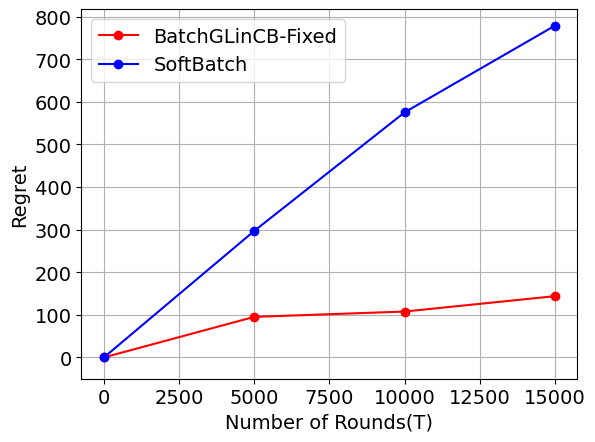

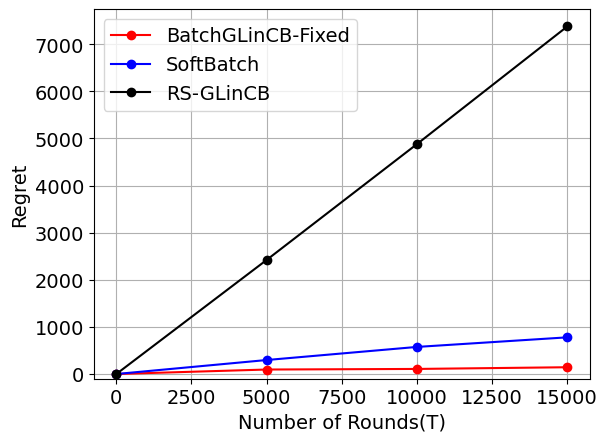

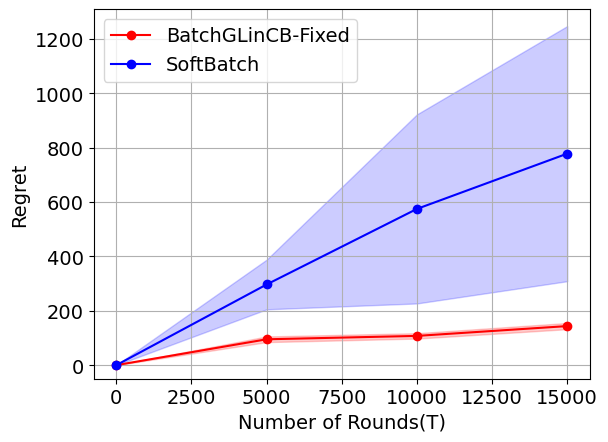

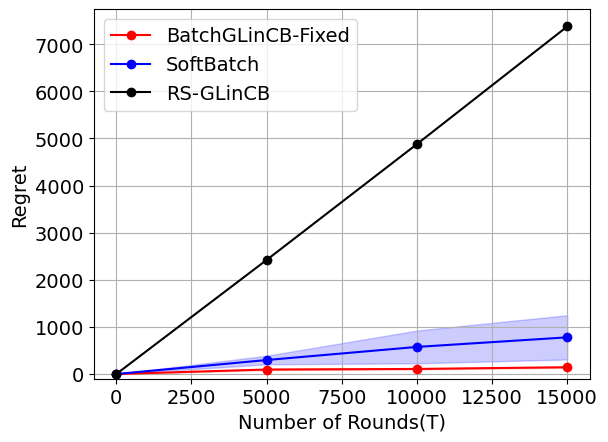

[0, 5.22798317347503, 4.967958467352092, 5.6958113081176664]
[0, 45.69792877944664, 173.9891689552969, 234.75472372580768]


In [ ]:
horizons  = [5000 , 10000 , 15000]

batchglincb_regret_mean , batchglincb_regret_std = aggregate("Results/NC_Data_Files_BatchGLinCB-Fixed" , "regret_array" , ["S=10_" , "eps=0.0"] , [f"T={h}_" for h in horizons] , np.sum , add_zero = True)
softbatch_regret_mean , softbatch_regret_std = aggregate("Results/NC_Data_Files_SoftBatch" , "regret_array" , ["S=10_" , "eps=0.0"] , [f"T={h}_" for h in horizons] , np.sum, add_zero = True)
rs_regret_mean , rs_regret_std = aggregate("Results/NC_Data_Files_RS_GLinCB" , "regret_array" , ["S=10_" , "eps=0.0"] , [f"T={h}_" for h in horizons] , np.sum, add_zero = True)

horizons = [0] + horizons

plt.plot(horizons , batchglincb_regret_mean , '-o', color = "r" , label = "BatchGLinCB-Fixed")
plt.plot(horizons , softbatch_regret_mean , '-o', color = "b" , label = "SoftBatch")

plt.grid()
plt.legend()
plt.xlabel("Number of Rounds(T)")
plt.ylabel("Regret")

plt.ylim(-50,)
plt.savefig("Plots/non_contextual.pdf")
plt.show()

plt.plot(horizons , batchglincb_regret_mean , '-o', color = "r" , label = "BatchGLinCB-Fixed")
plt.plot(horizons , softbatch_regret_mean , '-o', color = "b" , label = "SoftBatch")
plt.plot(horizons , rs_regret_mean , '-o', color = "k" , label = "RS-GLinCB")

plt.grid()
plt.legend()
plt.xlabel("Number of Rounds(T)")
plt.ylabel("Regret")

plt.ylim(-100,)
# plt.yscale("log")
plt.show()

plt.plot(horizons , batchglincb_regret_mean , '-o', color = "r" , label = "BatchGLinCB-Fixed")
plt.fill_between(horizons , np.array(batchglincb_regret_mean) - 2*np.array(batchglincb_regret_std) , np.array(batchglincb_regret_mean) + 2*np.array(batchglincb_regret_std) , color = "r" , alpha=0.2)
# plt.plot(horizons , np.array(batchglincb_regret_mean) - 2*np.array(batchglincb_regret_std) , "--", color = "r")
# plt.plot(horizons , np.array(batchglincb_regret_mean) + 2*np.array(batchglincb_regret_std) , "--", color = "r")


plt.plot(horizons , softbatch_regret_mean , '-o', color = "b" , label = "SoftBatch")
plt.fill_between(horizons , np.array(softbatch_regret_mean) - 2*np.array(softbatch_regret_std) , np.array(softbatch_regret_mean) + 2*np.array(softbatch_regret_std) , color = "b" , alpha=0.2)
# plt.plot(horizons , np.array(softbatch_regret_mean) - 2*np.array(softbatch_regret_std) , "--", color = "b" , alpha=0.5)
# plt.plot(horizons , np.array(softbatch_regret_mean) + 2*np.array(softbatch_regret_std) , "--", color = "b" , alpha=0.5)

plt.grid()
plt.legend()
plt.xlabel("Number of Rounds(T)")
plt.ylabel("Regret")

plt.ylim(-50,)
plt.show()

plt.plot(horizons , batchglincb_regret_mean , '-o', color = "r" , label = "BatchGLinCB-Fixed")
plt.fill_between(horizons , np.array(batchglincb_regret_mean) - 2*np.array(batchglincb_regret_std) , np.array(batchglincb_regret_mean) + 2*np.array(batchglincb_regret_std) , color = "r" , alpha=0.2)
# plt.plot(horizons , np.array(batchglincb_regret_mean) - 2*np.array(batchglincb_regret_std) , "--", color = "r" , alpha=0.5)
# plt.plot(horizons , np.array(batchglincb_regret_mean) + 2*np.array(batchglincb_regret_std) , "--", color = "r" , alpha=0.5)

plt.plot(horizons , softbatch_regret_mean , '-o', color = "b" , label = "SoftBatch")
plt.fill_between(horizons , np.array(softbatch_regret_mean) - 2*np.array(softbatch_regret_std) , np.array(softbatch_regret_mean) + 2*np.array(softbatch_regret_std) , color = "b" , alpha=0.2)
# plt.plot(horizons , np.array(softbatch_regret_mean) - 2*np.array(softbatch_regret_std) , "--", color = "b" , alpha=0.5)
# plt.plot(horizons , np.array(softbatch_regret_mean) + 2*np.array(softbatch_regret_std) , "--", color = "b" , alpha=0.5)

plt.plot(horizons , rs_regret_mean , '-o', color = "k" , label = "RS-GLinCB")

plt.grid()
plt.legend()
plt.xlabel("Number of Rounds(T)")
plt.ylabel("Regret")

plt.ylim(-100,)
plt.savefig("Plots/non_contextual_with_rs_and_error.pdf")
plt.show()



print(batchglincb_regret_std)
print(softbatch_regret_std)

### Misspecified Setting

In [ ]:
alg_names = ["BatchGLinCB-Fixed" , "RS_GLinCB", "SoftBatch"]
for run in range(0,10):
    print(f"\nSTARTING RUN {run} \n")
    for horizon in [5000,10000,15000]:
        for alg_name in alg_names:
            reward_seed = ((123 * run)%1e7) + run
            command = f"caffeinate python3 main.py  --horizon {horizon} --failure_level 0.05 --dimension 5 --number_arms 500 --param_norm_ub 10   --alg_name {alg_name} --reward_seed {int(reward_seed)}  --arm_seed 1824"
            os.system(command)

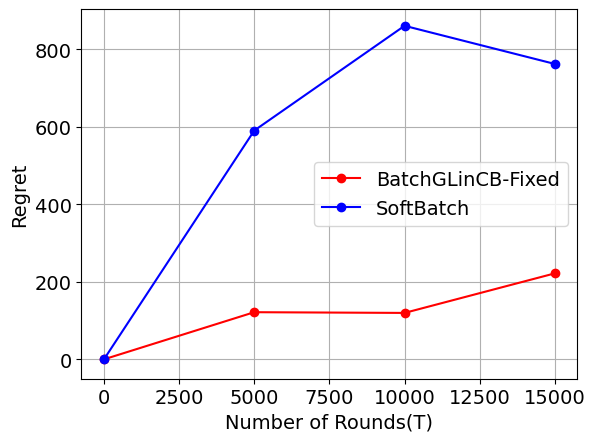

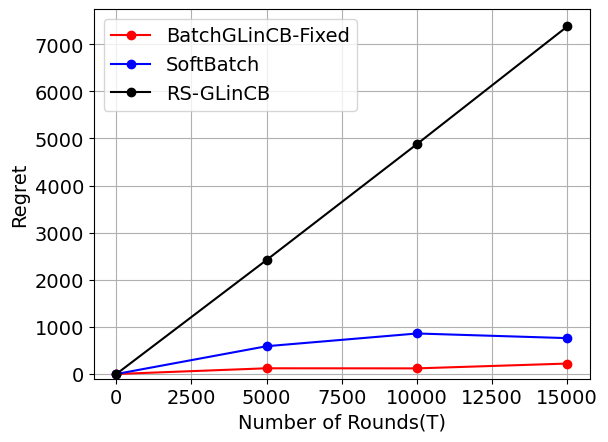

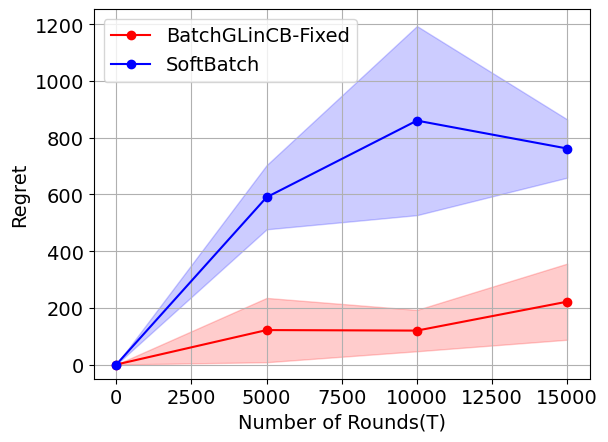

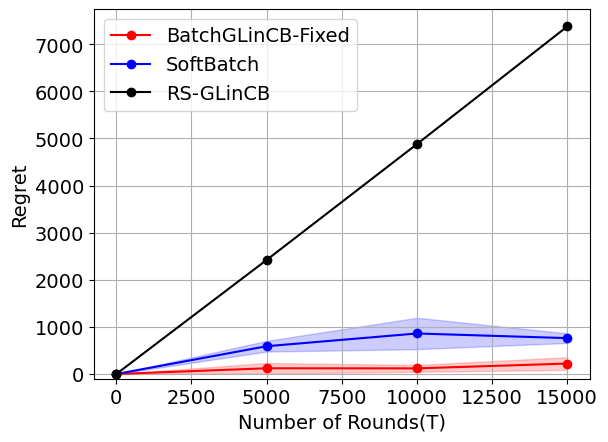

[0, 56.694530075484906, 36.46598570891402, 67.1408798360204]
[0, 56.577377621245006, 166.75914583417944, 51.377419668160414]


In [ ]:
horizons  = [5000,10000,15000 ]


batchglincb_regret_mean , batchglincb_regret_std = aggregate("Results/NC_Data_Files_BatchGLinCB-Fixed" , "regret_array" , ["S=10_" , "eps=-1"] , [f"T={h}_" for h in horizons] , np.sum , add_zero = True)
softbatch_regret_mean , softbatch_regret_std = aggregate("Results/NC_Data_Files_SoftBatch" , "regret_array" , ["S=10_" , "eps=-1"] , [f"T={h}_" for h in horizons] , np.sum, add_zero = True)
rs_regret_mean , rs_regret_std = aggregate("Results/NC_Data_Files_RS_GLinCB" , "regret_array" , ["S=10_" , "eps=-1"] , [f"T={h}_" for h in horizons] , np.sum, add_zero = True)

horizons = [0] + horizons

plt.plot(horizons , batchglincb_regret_mean , '-o', color = "r" , label = "BatchGLinCB-Fixed")
plt.plot(horizons , softbatch_regret_mean , '-o', color = "b" , label = "SoftBatch")

plt.grid()
plt.legend()
plt.xlabel("Number of Rounds(T)")
plt.ylabel("Regret")

plt.ylim(-50,)
plt.savefig("Plots/misspecified.pdf")
plt.show()

plt.plot(horizons , batchglincb_regret_mean , '-o', color = "r" , label = "BatchGLinCB-Fixed")
plt.plot(horizons , softbatch_regret_mean , '-o', color = "b" , label = "SoftBatch")
plt.plot(horizons , rs_regret_mean , '-o', color = "k" , label = "RS-GLinCB")

plt.grid()
plt.legend()
plt.xlabel("Number of Rounds(T)")
plt.ylabel("Regret")

plt.ylim(-100,)
# plt.yscale("log")
plt.show()

plt.plot(horizons , batchglincb_regret_mean , '-o', color = "r" , label = "BatchGLinCB-Fixed")
plt.fill_between(horizons , np.array(batchglincb_regret_mean) - 2*np.array(batchglincb_regret_std) , np.array(batchglincb_regret_mean) + 2*np.array(batchglincb_regret_std) , color = "r" , alpha=0.2)
# plt.plot(horizons , np.array(batchglincb_regret_mean) - 2*np.array(batchglincb_regret_std) , "--", color = "r")
# plt.plot(horizons , np.array(batchglincb_regret_mean) + 2*np.array(batchglincb_regret_std) , "--", color = "r")


plt.plot(horizons , softbatch_regret_mean , '-o', color = "b" , label = "SoftBatch")
plt.fill_between(horizons , np.array(softbatch_regret_mean) - 2*np.array(softbatch_regret_std) , np.array(softbatch_regret_mean) + 2*np.array(softbatch_regret_std) , color = "b" , alpha=0.2)
# plt.plot(horizons , np.array(softbatch_regret_mean) - 2*np.array(softbatch_regret_std) , "--", color = "b")
# plt.plot(horizons , np.array(softbatch_regret_mean) + 2*np.array(softbatch_regret_std) , "--", color = "b")

plt.grid()
plt.legend()
plt.xlabel("Number of Rounds(T)")
plt.ylabel("Regret")

plt.ylim(-50,)
plt.show()

plt.plot(horizons , batchglincb_regret_mean , '-o', color = "r" , label = "BatchGLinCB-Fixed")
plt.fill_between(horizons , np.array(batchglincb_regret_mean) - 2*np.array(batchglincb_regret_std) , np.array(batchglincb_regret_mean) + 2*np.array(batchglincb_regret_std) , color = "r" , alpha=0.2)
# plt.plot(horizons , np.array(batchglincb_regret_mean) - 2*np.array(batchglincb_regret_std) , "--", color = "r")
# plt.plot(horizons , np.array(batchglincb_regret_mean) + 2*np.array(batchglincb_regret_std) , "--", color = "r")

plt.plot(horizons , softbatch_regret_mean , '-o', color = "b" , label = "SoftBatch")
plt.fill_between(horizons , np.array(softbatch_regret_mean) - 2*np.array(softbatch_regret_std) , np.array(softbatch_regret_mean) + 2*np.array(softbatch_regret_std) , color = "b" , alpha=0.2)
# plt.plot(horizons , np.array(softbatch_regret_mean) - 2*np.array(softbatch_regret_std) , "--", color = "b")
# plt.plot(horizons , np.array(softbatch_regret_mean) + 2*np.array(softbatch_regret_std) , "--", color = "b")

plt.plot(horizons , rs_regret_mean , '-o', color = "k" , label = "RS-GLinCB")

plt.grid()
plt.legend()
plt.xlabel("Number of Rounds(T)")
plt.ylabel("Regret")

plt.ylim(-100,)
plt.savefig("Plots/misspecified_with_rs_and_error.pdf")
plt.show()



print(batchglincb_regret_std)
print(softbatch_regret_std)

### Contextual


In [ ]:
alg_names = ["BatchGLinCB" , "RS_GLinCB", "SoftBatch"]
for run in range(0,10):
    print(f"\nSTARTING RUN {run} \n")
    for horizon in [5000,10000,15000]:
        for alg_name in alg_names:
            reward_seed = ((123 * run)%1e7) + run
            command = f"caffeinate python3 main.py  --horizon {horizon} --failure_level 0.05 --dimension 5 --number_arms 500 --param_norm_ub 10   --alg_name {alg_name} --contextual --reward_seed {int(reward_seed)} --epsilon 0"
            os.system(command)

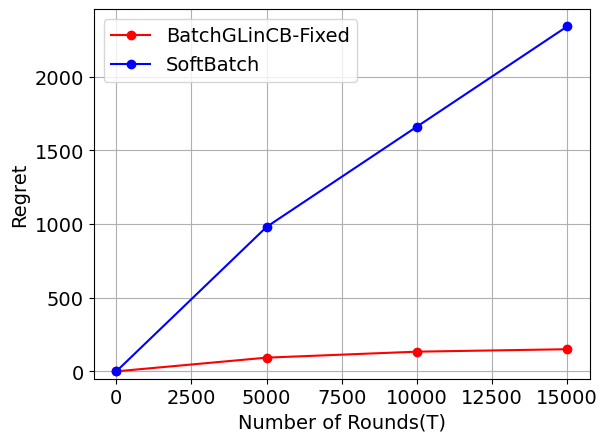

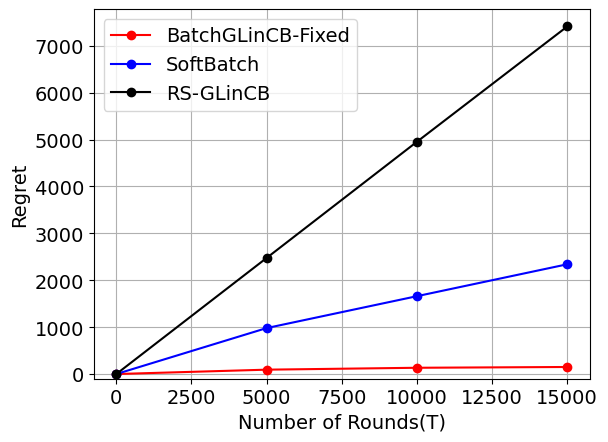

[0, 0.6216969213624909, 0.6328729327905216, 1.085056865319805]
[0, 0.5345340687894103, 1.1928491058715303, 2.9192774901280365]


In [ ]:
horizons  = [5000,10000,15000]


batchglincb_regret_mean , batchglincb_regret_std = aggregate("Results/C_Data_Files_BatchGLinCB" , "regret_array" , ["S=10_" , "eps=0.0"] , [f"T={h}_" for h in horizons] , np.sum , add_zero = True)
softbatch_regret_mean , softbatch_regret_std = aggregate("Results/C_Data_Files_SoftBatch" , "regret_array" , ["S=10_" , "eps=0.0"] , [f"T={h}_" for h in horizons] , np.sum, add_zero = True)
rs_regret_mean , rs_regret_std = aggregate("Results/C_Data_Files_RS_GLinCB" , "regret_array" , ["S=10_" , "eps=0.0"] , [f"T={h}_" for h in horizons] , np.sum, add_zero = True)

horizons = [0] + horizons

plt.plot(horizons , batchglincb_regret_mean , '-o', color = "r" , label = "BatchGLinCB-Fixed")
plt.plot(horizons , softbatch_regret_mean , '-o', color = "b" , label = "SoftBatch")

plt.grid()
plt.legend()
plt.xlabel("Number of Rounds(T)")
plt.ylabel("Regret")

plt.ylim(-50,)
plt.savefig("Plots/contextual.pdf")
plt.show()

plt.plot(horizons , batchglincb_regret_mean , '-o', color = "r" , label = "BatchGLinCB-Fixed")
plt.plot(horizons , softbatch_regret_mean , '-o', color = "b" , label = "SoftBatch")
plt.plot(horizons , rs_regret_mean , '-o', color = "k" , label = "RS-GLinCB")

plt.grid()
plt.legend()
plt.xlabel("Number of Rounds(T)")
plt.ylabel("Regret")

plt.ylim(-100,)
plt.savefig("Plots/contextual_with_rs.pdf")
plt.show()

print(batchglincb_regret_std)
print(softbatch_regret_std)